In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from IPython.core.debugger import set_trace

import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split, RandomizedSearchCV


/Users/macbook/opt/anaconda3/envs/Deep/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_excel('CBA.AX5y.xls')

In [3]:
df.columns = df.columns.str.lower()

In [4]:
df = df.drop(labels = ['open', 'high', 'low', 'adj close', 'volume'], axis=1)

In [5]:
df.head()

,date,close
0,2017-09-21,76.070000
1,2017-09-22,76.620003
2,2017-09-25,75.809998
3,2017-09-26,75.099998
4,2017-09-27,74.849998


In [6]:
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

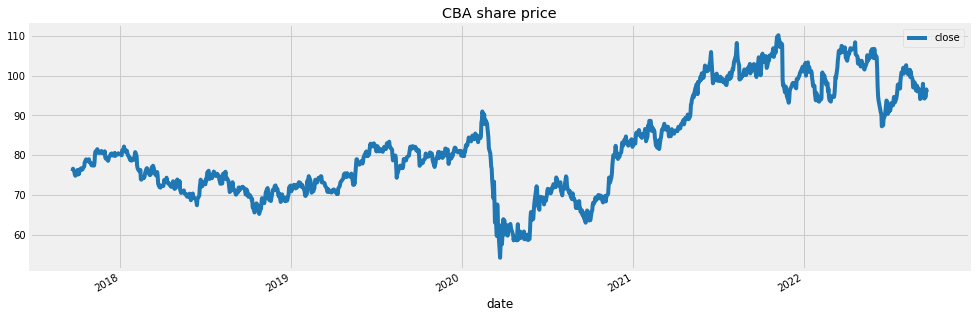

In [7]:
df.plot(style='-',
        figsize=(15, 5),
        color=color_pal[0],
        title='CBA share price')
plt.show()

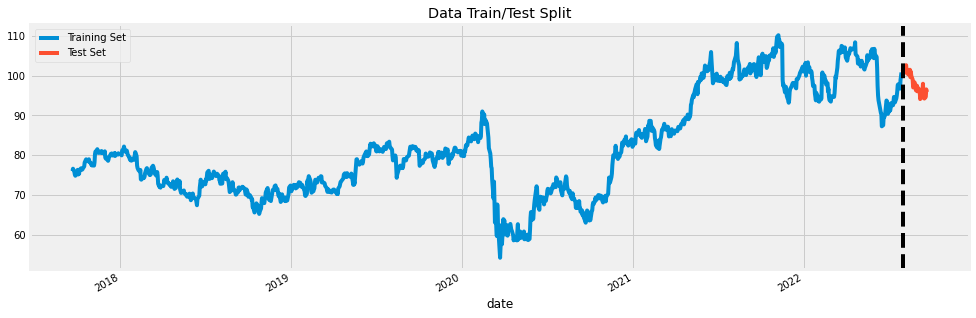

In [8]:
train = df.loc[df.index < '2022-08-01']
test = df.loc[df.index >= '2022-08-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2022-08-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [9]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df = create_features(df)

In [10]:
df.head()

,close,dayofweek,quarter,month,year
date,,,,,
2017-09-21,76.070000,3,3,9,2017
2017-09-22,76.620003,4,3,9,2017
2017-09-25,75.809998,0,3,9,2017
2017-09-26,75.099998,1,3,9,2017
2017-09-27,74.849998,2,3,9,2017


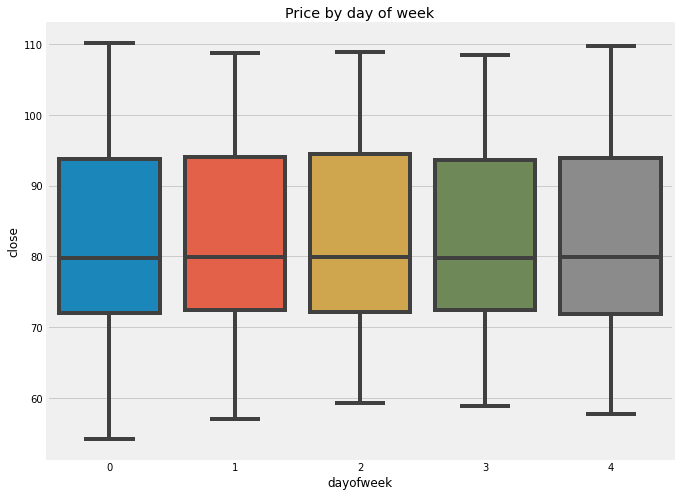

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='close')
ax.set_title('Price by day of week')
plt.show()

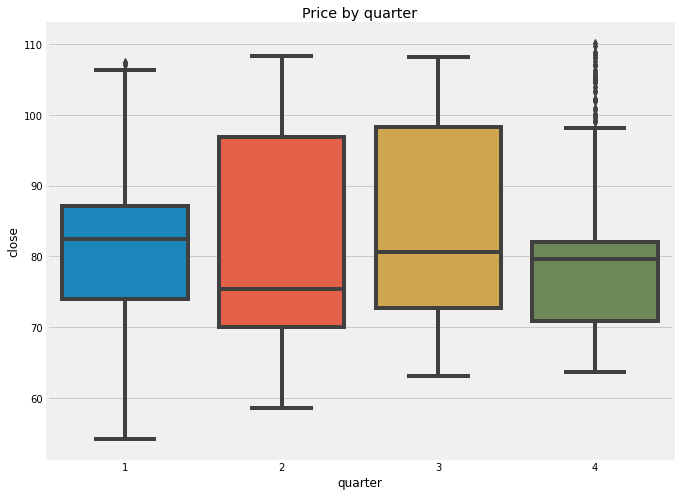

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='close')
ax.set_title('Price by quarter')
plt.show()

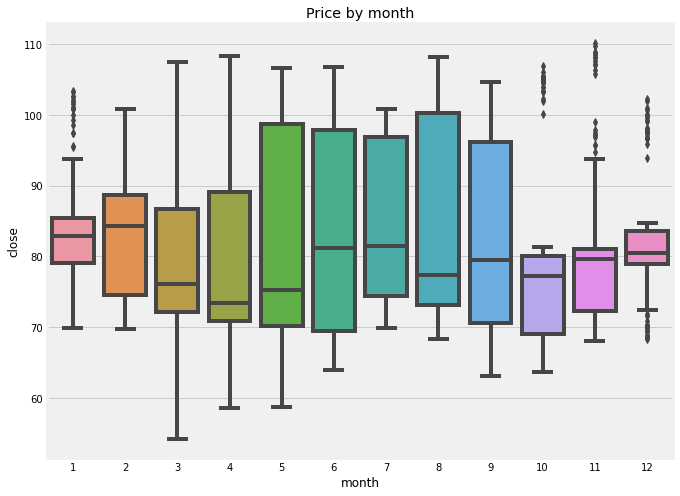

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='close')
ax.set_title('Price by month')
plt.show()

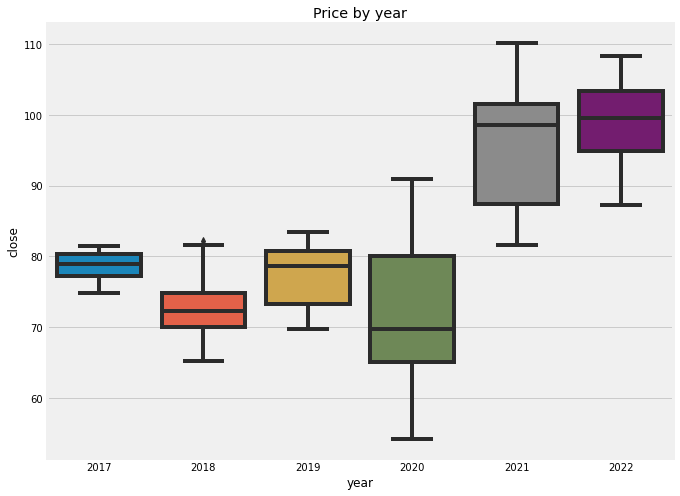

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='close')
ax.set_title('Price by year')
plt.show()

In [15]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year']
TARGET = 'close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [16]:
df2 = df[['close']].copy()

In [17]:
df.head()

,close,dayofweek,quarter,month,year
date,,,,,
2017-09-21,76.070000,3,3,9,2017
2017-09-22,76.620003,4,3,9,2017
2017-09-25,75.809998,0,3,9,2017
2017-09-26,75.099998,1,3,9,2017
2017-09-27,74.849998,2,3,9,2017


In [18]:
df2['target'] = df2.close.shift(-1)

In [19]:
df2.head()

,close,target
date,,
2017-09-21,76.070000,76.620003
2017-09-22,76.620003,75.809998
2017-09-25,75.809998,75.099998
2017-09-26,75.099998,74.849998
2017-09-27,74.849998,75.120003


### Train Test split

In [20]:
def train_test_split(data, perc):
    data = data.values
    n = int(len(data) * (1 - perc))
    return data[:n], data[n:]

In [21]:
train, test = train_test_split(df, 0.2)

In [22]:
print(len(df2))
print(len(train))
print(len(test))

1267
1013
254


In [23]:
X = train[:, :-1]
y = train[:, -1]

In [ ]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X,y)